# **Business Understanding**

Each row is a sequence of a protein that interacts with DNA, RNA, both, or neither. The dataset can be used to predict which of the four possibilities the sequence is. can be used by companies or healthcare people

### Import statements and initializing the dataframe

In [1]:
import pandas as pd
import numpy as np
sequences_df = pd.read_csv("data/sequences_training_pfeatured.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/sequences_training_pfeatured.csv'

# **Data Understanding**

8796 rows, 519 columns. pfeature already did the real work. all that's left is running the algorithms on the numbers that it created. every column is ratio data type.


The last column is the target column. The DRNA class is majorly underrepresented. nonDRNA is majorly overrepresented.

In [183]:
print(f"rows: {sequences_df.shape[0]}")
print(f"columns: {sequences_df.shape[1]}")
print()

for i in sequences_df[sequences_df.columns[-1]].unique():
    print(f"label: {i} - count: {sequences_df[sequences_df.columns[-1]].value_counts()[i]}")

rows: 8795
columns: 546

label: nonDRNA - count: 7859
label: RNA - count: 523
label: DNA - count: 391
label: DRNA - count: 22


# **Data Preparation**
Normally I would do data cleaning here but there is no need because everything is numbers and there are no nulls

In [184]:
# i know that the actual dataset has no duplicates
print(f"Duplicates: {sequences_df.duplicated().sum()}")
print("There are no spelling issues, every column uses the same units for every row.")
print(f"Null values: {sequences_df.isna().sum().sum()}")
print("Any of the columns and rows could be useful so I don't want to remove any.")

Duplicates: 20
There are no spelling issues, every column uses the same units for every row.
Null values: 0
Any of the columns and rows could be useful so I don't want to remove any.


# **Modeling**
Drop columns that aren't useful. Really just the target column

Split the data between training and testing before encoding and scaling to prevent **data leakage**

In [185]:
from sklearn.model_selection import train_test_split

X = sequences_df.drop(["class"], axis=1)
y = sequences_df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Data Preparation**
Here, I oversample the smallest class: DRNA 

This is because it would be impossible to predict that class otherwise

In [186]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE:")
print(y_train.value_counts())



smote = SMOTE(
    sampling_strategy={'DRNA': 27},
    k_neighbors=3,
    random_state=42
)
smoted_X_train, smoted_y_train = smote.fit_resample(X_train, y_train)



print("\nAfter SMOTE:")
print(pd.Series(smoted_y_train).value_counts())

Before SMOTE:
class
nonDRNA    6287
RNA         418
DNA         313
DRNA         18
Name: count, dtype: int64

After SMOTE:
class
nonDRNA    6287
RNA         418
DNA         313
DRNA         27
Name: count, dtype: int64


### Reduce dimensionality for eventual SVM

I use the Random Forest model to find the most important features.

Class_weight being "balanced_subsample" makes it so that the localized weighting for each tree helps to provide stability and further reduce the risk of overfitting to the majority class distribution in any single sample.

Another option is class_weight being "balanced" which would make it so that every tree has the same weights. This would connect with the smote algorithm implemented before. If every tree respects class imbalance then the resulting algorithm will be sure to respect it. Likely too much and will be overfit.

In [187]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=750,
    max_depth=None,
    class_weight="balanced_subsample",
    random_state=42
)

rf.fit(smoted_X_train, smoted_y_train)
RF_y_pred = rf.predict(X_test)

I chose to keep 1/3 of the features because I didn't want to set an arbitrary importance threshold value. Especially because the importance is very flat for the last 2/3 of the features. Arbitrarily keeping 1/3 of the features means that I get the most important values and some of the less important ones as well

In [188]:
import matplotlib.pyplot as plt
feature_importance = pd.Series(
    rf.feature_importances_,
    index=smoted_X_train.columns
).sort_values(ascending=False)



threshold = X.shape[1] // 3
top_features = feature_importance.head(threshold).index.tolist()

#### Scale the data for svm

In [189]:
top_X_train = smoted_X_train[top_features]
top_X_test = X_test[top_features]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(top_X_train), columns=top_X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(top_X_test), columns=top_X_test.columns)

# **Modeling**
algorithm fit and predict

In [190]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=5000
)

svm.fit(scaled_X_train, smoted_y_train)
svm_y_pred = svm.predict(scaled_X_test)

# **Evaluation**

In [191]:
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_test, RF_y_pred)
results = []
total = cm.sum()
classes = np.unique(y_test)



for i, cls in enumerate(classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = total - TP - FP - FN

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / total
    mcc = (
        (TP * TN - FP * FN) /
        np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
        if all(x > 0 for x in [(TP+FP),(TP+FN),(TN+FP),(TN+FN)])
        else 0
    )

    results.append({
        "Class": cls,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "Accuracy": accuracy,
        "MCC": mcc
    })

metrics_df = pd.DataFrame(results)
print("This is proof that the Decision Tree alone is not enough. It is unable to classify drna sequences")
print(f"Average MCC: {metrics_df['MCC'].mean()}")
metrics_df

This is proof that the Decision Tree alone is not enough. It is unable to classify drna sequences
Average MCC: 0.27554562568133545


,Class,Sensitivity (Recall),Specificity,Accuracy,MCC
0,DNA,0.051282,0.999405,0.957362,0.195988
1,DRNA,0.000000,1.000000,0.997726,0.000000
2,RNA,0.295238,0.998791,0.956794,0.513423
3,nonDRNA,0.998092,0.187166,0.911882,0.392772


In [192]:
cm = confusion_matrix(y_test, svm_y_pred)
results = []
total = cm.sum()
classes = np.unique(y_test)



for i, cls in enumerate(classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = total - TP - FP - FN

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / total
    mcc = (
        (TP * TN - FP * FN) /
        np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
        if all(x > 0 for x in [(TP+FP),(TP+FN),(TN+FP),(TN+FN)])
        else 0
    )

    results.append({
        "Class": cls,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "Accuracy": accuracy,
        "MCC": mcc
    })

metrics_df = pd.DataFrame(results)
print("This is the result of the SVM with 1/3 of the features:")
print(f"Average MCC: {metrics_df['MCC'].mean()}")
metrics_df

This is the result of the SVM with 1/3 of the features:
Average MCC: 0.33630107887156524


,Class,Sensitivity (Recall),Specificity,Accuracy,MCC
0,DNA,0.294872,0.957763,0.928368,0.231235
1,DRNA,0.250000,0.992023,0.990335,0.125374
2,RNA,0.552381,0.968561,0.943718,0.509736
3,nonDRNA,0.930025,0.582888,0.893121,0.478860


# Visualization

It's impossible to visualize an SVM with so many features. However, these are the features that are most important for classifying the sequences:

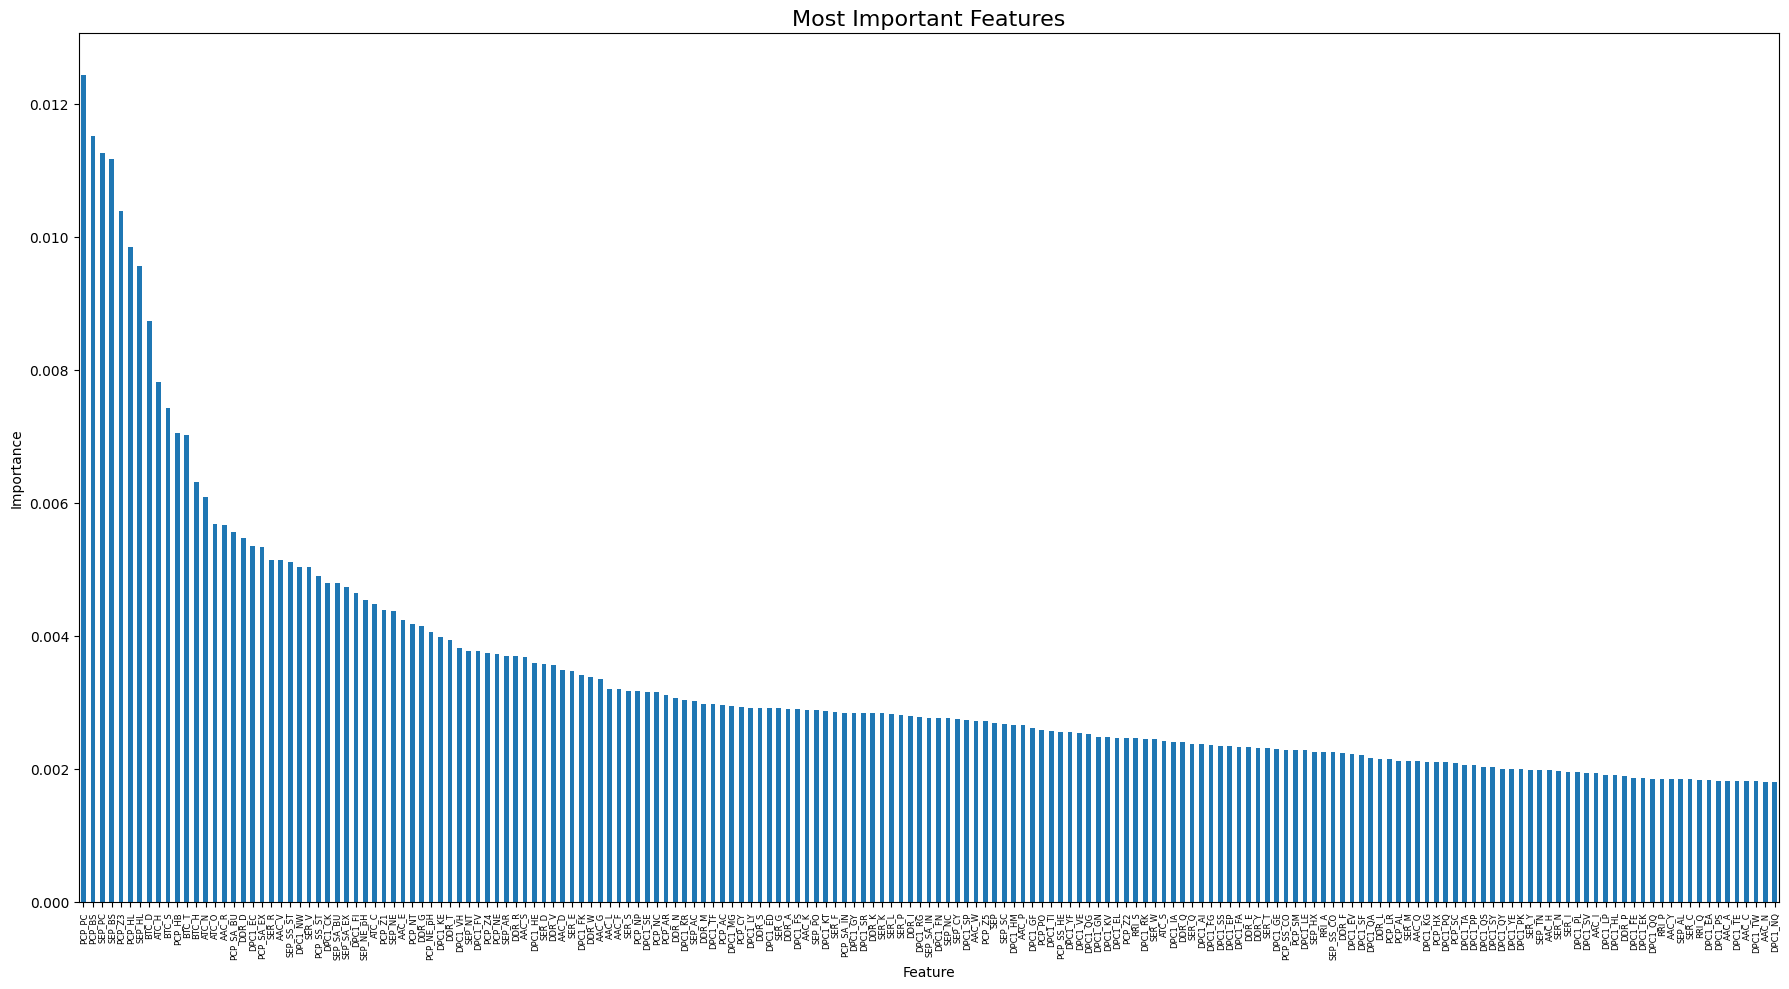

In [193]:
ax = feature_importance.head(threshold).plot(
    kind="bar", 
    figsize=(18, 10)
)

# labels
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")

# X-axis tick formatting
ax.tick_params(axis='x', labelsize=6)
ax.set_title("Most Important Features", fontsize=16)

# show graph
plt.tight_layout()
plt.show()


In [195]:
feature_importance.head(15)

PCP_PC    0.012440
PCP_BS    0.011512
SEP_PC    0.011266
SEP_BS    0.011168
PCP_Z3    0.010385
PCP_HL    0.009855
SEP_HL    0.009566
BTC_D     0.008738
ATC_H     0.007813
BTC_S     0.007428
PCP_HB    0.007050
BTC_T     0.007016
BTC_H     0.006320
ATC_N     0.006092
ATC_O     0.005682
dtype: float64

PCP_PC: composition of positively charged residues

PCP_BS: composition of basic residues

SEP_PC: Shannon entropy of positive and negative charged residues

SEP_BS: Shannon entropy of basic residues

PCP_Z3: Composition of residues having Z3 advanced Physico-chemical properties

PCP_HL: Composition of hydrophilic residues

SEP_HL: Shannon entropy of hydrophilic residues

BTC_D: Composition of Double bonds

ATC_H: Atomic Composition of Hydrogen

BTC_S:  Composition of Single bonds

PCP_HB: Composition of hydrophobic residues

BTC_T: Composition of total bonds

BTC_H: Composition of Hydrogen bonds

ATC_N: Atomic Composition of Nitrogen

ATC_O: Atomic Composition of Oxygen

# Deployment

It may overrepresent DRNA sequences but more research needs to be done

In [194]:
test_sequences_df = pd.read_csv("data/sequences_testing_pfeatured.csv")

top_X_deploy = test_sequences_df[top_features]
scaled_dep = pd.DataFrame(scaler.transform(top_X_deploy), columns=top_X_deploy.columns)
svm_pred = svm.predict(scaled_dep)
pd.Series(svm_pred).value_counts()


nonDRNA    7777
RNA         527
DNA         433
DRNA         57
Name: count, dtype: int64